# 1.Dataset

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(device))
else:
    print('CPU')

Tesla V100-SXM2-16GB


In [3]:
def load_cifar10(batch_size, resize=None):
    """Download the CIFAR-10 dataset and then load it into memory."""
    train_trans = [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),  # Random horizontal flip
        transforms.RandomRotation(15)       # Random rotation, range ±15 degrees
    ]
    test_trans = transforms.Compose([
        transforms.ToTensor()
    ])
    if resize:
        train_trans.insert(0, transforms.Resize(resize))
    train_trans = transforms.Compose(train_trans)

    cifar10_train = datasets.CIFAR10(root="./data", train=True, transform=train_trans, download=True)
    cifar10_test = datasets.CIFAR10(root="./data", train=False, transform=test_trans, download=True)

    return (torch.utils.data.DataLoader(cifar10_train, batch_size, shuffle=True, num_workers=2),
            torch.utils.data.DataLoader(cifar10_test, batch_size, shuffle=False, num_workers=2))


In [4]:
batch_size = 128
train_iter, test_iter = load_cifar10(batch_size)

100%|██████████| 170498071/170498071 [00:06<00:00, 27226763.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Getting some random training images
X, y = next(iter(train_iter))
X, y = X.to(device), y.to(device)
print(X.size())
print(y.size())

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([128, 3, 32, 32])
torch.Size([128])


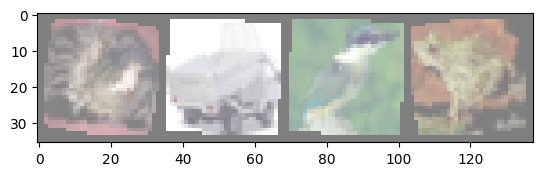

cat truck bird frog


In [6]:
def imshow(img):
    """Show an image."""
    img = img / 2 + 0.5  # unnormalize
    if img.is_cuda:
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show images
imshow(torchvision.utils.make_grid(X[:4]))
# Print labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
print(' '.join(f'{class_names[y[j]]}' for j in range(4)))

# 2. Basic architecture


In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, strides=1, padding='same', rate=0.4, drop=True):
        super(ConvBNRelu, self).__init__()
        self.drop = drop

        if padding == 'same':
            pad = kernel_size // 2
        else:
            pad = 0

        # Convolution layer
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                              stride=strides, padding=pad, bias=False)
        # Batch normalization layer
        self.batchnorm = nn.BatchNorm2d(num_features=out_channels)
        # Dropout layer (optional)
        if self.drop:
            self.dropout = nn.Dropout(p=rate)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = F.relu(x)
        if self.drop:
            x = self.dropout(x)
        return x

In [9]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, kernel_size, rate=0.3, drop=True):
        super(IntermediateBlock, self).__init__()
        self.convs = nn.ModuleList([
            ConvBNRelu(in_channels=in_channels,out_channels=out_channels, kernel_size=kernel_size, padding='same', rate=rate, drop=drop)
            for i in range(num_layers)
        ])
        self.fc = nn.Linear(in_channels, num_layers)

    def forward(self, x):
        # Compute the average of each channel
        avg_channels = torch.mean(x, dim=[2, 3])
        # Compute the coefficients
        a = torch.softmax(self.fc(avg_channels), dim=1)

        # Apply each convolutional layer to the input and collect the outputs
        conv_outputs = torch.stack([(conv(x)) for conv in self.convs], dim=1)

        # Combine the outputs
        x_prime = torch.einsum('blchw,bl->bchw', conv_outputs, a)
        return x_prime

class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        # Define the first fully connected layer
        self.fc1 = nn.Linear(in_channels, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        # Define the second fully connected layer
        self.fc2 = nn.Linear(512, num_classes)


    def forward(self, x):
        # Compute the average of each channel
        avg_channels = torch.mean(x, dim=[2, 3])
        # Pass through the first fully connected layer and apply ReLU activation
        x = self.fc1(avg_channels)
        x = self.relu(x)
        x = self.dropout(x)
        # Compute the logits vector
        o = self.fc2(x)
        return o

In [10]:
class CustomCIFAR10Model(nn.Module):
    def __init__(self):
        super(CustomCIFAR10Model, self).__init__()
        self.block1 = IntermediateBlock(3, 64, 2, 3, drop=True, rate=0.3)
        self.block2 = IntermediateBlock(64, 64, 2, 3, drop=False)
        self.maxPooling1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block3 = IntermediateBlock(64, 128, 2, 3, drop=True, rate=0.3)
        self.block4 = IntermediateBlock(128, 128, 2, 3, drop=False)
        self.maxPooling2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block5 = IntermediateBlock(128, 256, 3, 3, drop=True, rate=0.4)
        self.block6 = IntermediateBlock(256, 256, 3, 3, drop=True, rate=0.4)
        self.block7 = IntermediateBlock(256, 256, 3, 3, drop=False)
        self.maxPooling3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block8 = IntermediateBlock(256, 512, 3, 3, drop=True, rate=0.4)
        self.block9 = IntermediateBlock(512, 512, 3, 3, drop=True, rate=0.4)
        self.block10 = IntermediateBlock(512, 512, 3, 3, drop=False)
        self.maxPooling4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block11 = IntermediateBlock(512, 512, 3, 3,drop=True, rate=0.4)
        self.block12 = IntermediateBlock(512, 512, 3, 3, drop=True, rate=0.4)
        self.block13 = IntermediateBlock(512, 512, 3, 3, drop=False)
        self.maxPooling5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.output_block = OutputBlock(512, 10)


    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.maxPooling1(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.maxPooling2(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.maxPooling3(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.maxPooling4(x)
        x = self.block11(x)
        x = self.block12(x)
        x = self.block13(x)
        x = self.maxPooling5(x)

        x = self.output_block(x)
        return x

## Test Model

## Adust model prameters here

In [11]:
# def init_weights(m):
    # if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
    #   torch.nn.init.xavier_uniform_(m.weight)

# Instantiate the model
model = CustomCIFAR10Model()

model.to(device)
# model.apply(init_weights)

CustomCIFAR10Model(
  (block1): IntermediateBlock(
    (convs): ModuleList(
      (0-1): 2 x ConvBNRelu(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.3, inplace=False)
      )
    )
    (fc): Linear(in_features=3, out_features=2, bias=True)
  )
  (block2): IntermediateBlock(
    (convs): ModuleList(
      (0-1): 2 x ConvBNRelu(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (fc): Linear(in_features=64, out_features=2, bias=True)
  )
  (maxPooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3): IntermediateBlock(
    (convs): ModuleList(
      (0-1): 2 x ConvBNRelu(
        (conv): Conv2d(64, 128, kernel_s

# 3.Loss and Evaluation

In [12]:
loss = torch.nn.CrossEntropyLoss()

In [13]:
num_epochs = 60
lr = 0.1
momentum = 0.9 # SGD Momentum
weight_decay = 1e-6  # learning rate decay
lr_drop = 20 # The learning rate decays to half of its original value every 20 epochs

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)

# Define learning rate scheduler
def lr_scheduler(epoch):
    return 0.5 ** (epoch // lr_drop)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_scheduler)

In [14]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.


In [15]:
def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0., device=device)
    n = torch.tensor(0., device=device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        c += metric(logits, y)
        n += len(y)

    return c / n

In [16]:
print(f'Training accuracy: {evaluate_metric(model, train_iter, correct)}. Testing accuracy: {evaluate_metric(model, test_iter, correct)}.')

Training accuracy: 0.09821999818086624. Testing accuracy: 0.09889999777078629.


# 4.Training

In [17]:
losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch


for epoch in range(num_epochs):
    model.train()
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        logits = model(X) # Computes the logits for the batch of images `X`

        l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

        optimizer.step() # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l)) # Stores the loss for this batch

    #Adjust the learning rate after each epoch
    scheduler.step()

    # Switch to evaluation mode for accuracy calculation
    model.eval()
    with torch.no_grad(): # Computing performance metrics does not require gradients
        train_acc = evaluate_metric(model, train_iter, correct)
        test_acc = evaluate_metric(model, test_iter, correct)

    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f'Training accuracy: {train_acc}. Testing accuracy: {test_acc}.') # Computes and displays training/testing dataset accuracy.



Epoch 1/60.
Training accuracy: 0.1876000016927719. Testing accuracy: 0.19529999792575836.

Epoch 2/60.
Training accuracy: 0.2362000048160553. Testing accuracy: 0.23800000548362732.

Epoch 3/60.
Training accuracy: 0.35288000106811523. Testing accuracy: 0.35120001435279846.

Epoch 4/60.
Training accuracy: 0.36263999342918396. Testing accuracy: 0.3779999911785126.

Epoch 5/60.
Training accuracy: 0.5662800073623657. Testing accuracy: 0.573199987411499.

Epoch 6/60.
Training accuracy: 0.6445599794387817. Testing accuracy: 0.6542999744415283.

Epoch 7/60.
Training accuracy: 0.664680004119873. Testing accuracy: 0.6815999746322632.

Epoch 8/60.
Training accuracy: 0.6862199902534485. Testing accuracy: 0.6909999847412109.

Epoch 9/60.
Training accuracy: 0.71697998046875. Testing accuracy: 0.7257999777793884.

Epoch 10/60.
Training accuracy: 0.7323399782180786. Testing accuracy: 0.7436000108718872.

Epoch 11/60.
Training accuracy: 0.7149800062179565. Testing accuracy: 0.7231000065803528.

Epoch 

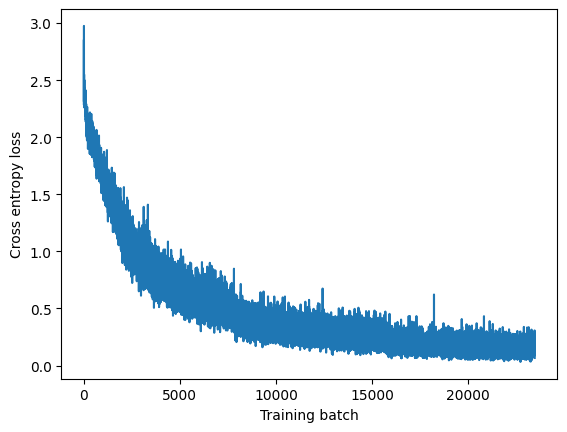

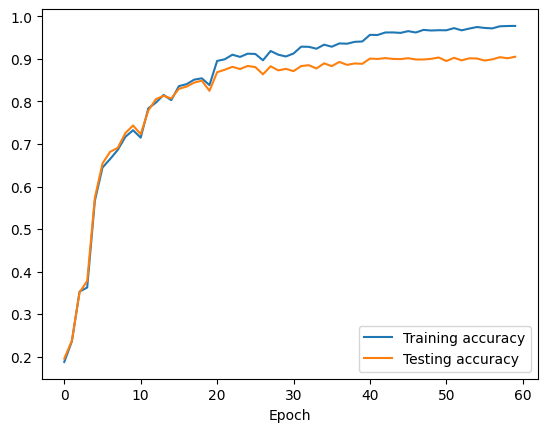

In [18]:
plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

if train_accs[0].is_cuda and test_accs[0].is_cuda :
  train_accs_cpu = [x.cpu().detach().numpy() for x in train_accs]
  test_accs_cpu = [x.cpu().detach().numpy() for x in test_accs]

plt.plot(train_accs_cpu, label='Training accuracy')
plt.plot(test_accs_cpu, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()